In [1]:
#!pip install mediapipe opencv-python pandas scikit-learn
import mediapipe as mp #Meidapipe
import cv2 #opencv
import csv
import numpy as np
import os
import sys
import tqdm
import random
import pandas as pd
import pickle # to save a model

# Package for visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Packages for model Implementation and Evaluation
from sklearn.metrics import confusion_matrix,classification_report
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

In [2]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import SpatialDropout1D
from keras.layers import InputLayer
from keras.layers import Conv1D
from keras.layers import Flatten
from keras.layers import Dropout
from tensorflow.keras.utils import to_categorical
from keras.layers import MaxPooling1D

In [3]:
#Initialising input image path and  output csv path
images_in_folder = 'C:\\Users\\jhaan\\Downloads\\Dataset'
#images_out_folder = 'fitness_poses_images_out_basic'
#csv_out_path = 'yoga_poses_landmark_dataset.csv'

#from mediapipe.solutions import drawing_utils as mp_drawing
mp_drawing = mp.solutions.drawing_utils # Drawing helpers
# from mediapipe.solutions import pose as mp_pose
mp_pose= mp.solutions.pose # Blazepose pose estimation model

In [4]:
import os
import csv
import sys
import cv2
import tqdm
import numpy as np
import mediapipe as mp

# Set the paths for input images and the output CSV file

csv_out_path = 'yoga_poses_landmark_dataset1.csv'
images_out_folder = 'fitness_poses_images_out_basic'

# Iterating through each Folder, converting images into landmark points and saving them to a CSV file
with open(csv_out_path, 'w') as csv_out_file:
    csv_out_writer = csv.writer(csv_out_file, delimiter=',', quoting=csv.QUOTE_MINIMAL)

    # folder names are used as pose class names
    pose_class_names = sorted([n for n in os.listdir(images_in_folder) if not n.startswith('.')])
    counter = 1
    for pose_class_name in pose_class_names:
        print('Extracting landmark points from dataset', pose_class_name, file=sys.stderr)
        if not os.path.exists(os.path.join(images_out_folder, pose_class_name)):
            os.makedirs(os.path.join(images_out_folder, pose_class_name))
        image_names = sorted([
            n for n in os.listdir(os.path.join(images_in_folder, pose_class_name))
            if not n.startswith('.')
        ])
        for image_name in tqdm.tqdm(image_names, position=0):
            # Load image.
            input_frame = cv2.imread(os.path.join(images_in_folder, pose_class_name, image_name))
            input_frame = cv2.cvtColor(input_frame, cv2.COLOR_BGR2RGB)

           # Applying Blazepose model on the image and extracting 33 3D landmark points.
            with mp_pose.Pose() as pose_tracker:
                result = pose_tracker.process(image=input_frame)
                pose_landmarks = result.pose_landmarks

            # Save Landmark points to a csv file.
            if pose_landmarks is not None:
                
                # check the number of landmarks and take pose landmarks.
                assert len(pose_landmarks.landmark) == 33, 'Unexpected number of predicted pose landmarks: {}'.format(len(pose_landmarks.landmark))
                pose_landmark = [[lmk.x, lmk.y, lmk.z] for lmk in pose_landmarks.landmark]

                # Write pose sample to CSV.
                pose_landmarks = np.around(pose_landmark, 5).flatten().astype(str).tolist()
                csv_out_writer.writerow([pose_class_name] + pose_landmarks)


Extracting landmark points from dataset Adho Mukha Svanasana
100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [04:31<00:00,  1.18it/s]
Extracting landmark points from dataset BALASANA
100%|████████████████████████████████████████████████████████████████████████████████| 261/261 [03:25<00:00,  1.27it/s]
Extracting landmark points from dataset UTKATA KONASANA
100%|████████████████████████████████████████████████████████████████████████████████| 180/180 [02:24<00:00,  1.25it/s]
Extracting landmark points from dataset VIRABHADRASANA
100%|████████████████████████████████████████████████████████████████████████████████| 209/209 [07:09<00:00,  2.05s/it]
Extracting landmark points from dataset VRIKSHASANA
100%|████████████████████████████████████████████████████████████████████████████████| 334/334 [04:21<00:00,  1.27it/s]


In [5]:
df_csv = pd.read_csv('./yoga_poses_landmark_dataset1.csv', header=None)

In [6]:
l1=['pose_name']
for i in range(1,34):
    l1.append('x'+str(i))
    l1.append('y'+str(i))
    l1.append('z'+str(i))

In [7]:
df_csv.to_csv('./yoga_poses_landmark_dataset_new11.csv', header=l1, index=False)

In [8]:
df_csv1 = pd.read_csv('./yoga_poses_landmark_dataset_new11.csv')
df_csv1

pose_name       x1       y1       z1       x2       y2  \
0     Adho Mukha Svanasana  0.51255  0.72271 -0.06939  0.49571  0.74738   
1     Adho Mukha Svanasana  0.56914  0.78736 -0.04211  0.58289  0.79472   
2     Adho Mukha Svanasana  0.60981  0.73095 -0.02633  0.62893  0.73618   
3     Adho Mukha Svanasana  0.54014  0.76076 -0.09753  0.56006  0.77120   
4     Adho Mukha Svanasana  0.35996  0.70324 -0.03186  0.33947  0.71399   
...                    ...      ...      ...      ...      ...      ...   
1151           VRIKSHASANA  0.25630  0.24405  0.20495  0.25462  0.23148   
1152           VRIKSHASANA  0.54245  0.12668 -0.45318  0.55250  0.11328   
1153           VRIKSHASANA  0.46805  0.24539 -0.64011  0.48047  0.22870   
1154           VRIKSHASANA  0.50272  0.22139 -0.18033  0.50743  0.20640   
1155           VRIKSHASANA  0.42180  0.36387 -0.78332  0.43354  0.34638   

           z2       x3       y3       z3  ...      z30      x31      y31  \
0    -0.10888  0.49218  0.74686 -0.10889  ... -0.09030  0.87879  0.88034   
1    -0.02245  0.58382  0.79329 -0.02254  ...  0.16459  0.14689  0.87059   
2    -0.00001  0.63077  0.73358 -0.00006  ...  0.32132  0.05536  0.88034   
3    -0.07502  0.56291  0.76970 -0.07497  ...  0.39135  0.15186  0.85156   
4    -0.07545  0.33654  0.71106 -0.07544  ... -0.13264  0.85920  0.84807   
...       ...      ...      ...      ...  ...      ...      ...      ...   
1151  0.18330  0.25164  0.22982  0.18328  ... -0.00287  0.24393  0.97923   
1152 -0.40451  0.55850  0.11340 -0.40459  ...  0.28987  0.50132  0.53053   
1153 -0.57668  0.48989  0.22795 -0.57661  ...  0.24510  0.49847  0.87207   
1154 -0.14932  0.51033  0.20665 -0.14930  ...  0.26938  0.51896  0.93901   
1155 -0.71442  0.44216  0.34566 -0.71427  ...  0.29859  0.39522  0.95606   

          z31      x32      y32      z32      x33      y33      z33  
0     0.34875  0.78911  0.92161 -0.25806  0.77612  0.90703  0.24612  
1    -0.14172  0.24892  0.90370  0.07002  0.23911  0.91070 -0.27126  
2    -0.16074  0.20473  0.90643  0.19393  0.19505  0.92314 -0.33403  
3    -0.04104  0.27583  0.88195  0.27128  0.26445  0.88739 -0.20759  
4     0.35368  0.75283  0.94305 -0.29861  0.72678  0.92300  0.25760  
...       ...      ...      ...      ...      ...      ...      ...  
1151  0.01453  0.16519  0.96654 -0.04811  0.25233  0.96893 -0.02125  
1152  0.55582  0.50007  0.88824  0.01557  0.52138  0.62121  0.51723  
1153  0.26612  0.45072  0.65527  0.12706  0.46229  0.90014  0.00781  
1154  0.12276  0.49651  0.69156  0.23207  0.51610  0.96354  0.00034  
1155  0.56444  0.42328  0.96545  0.19362  0.39969  1.02506  0.40572  

[1156 rows x 100 columns]

In [9]:
import csv
import random

# Set the path for your CSV file
csv_file_path = './yoga_poses_landmark_dataset_new11.csv'

# Read the CSV file into a list
with open(csv_file_path, 'r') as csv_file:
    csv_reader = csv.reader(csv_file)
    rows = list(csv_reader)

    
# Separate the header (first row) and the data rows
header = rows[0]
data = rows[1:]

# Shuffle the rows randomly
random.shuffle(data)

# Write the shuffled rows back to the CSV file, including the header
with open(csv_file_path, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(header)  # Write the header
    csv_writer.writerows(data)  # Write the shuffled data rows

print("CSV file rows shuffled (excluding header) successfully.")






CSV file rows shuffled (excluding header) successfully.


In [7]:
df = pd.read_csv('./yoga_poses_landmark_dataset_new11.csv')
df

pose_name       x1       y1       z1       x2       y2  \
0              VRIKSHASANA  0.45108  0.22382 -0.38753  0.45272  0.21546   
1     Adho Mukha Svanasana  0.38190  0.61599 -0.03467  0.36080  0.62489   
2          UTKATA KONASANA  0.51682  0.11190 -0.27063  0.52912  0.09247   
3                 BALASANA  0.38900  0.68686 -0.14106  0.37749  0.67608   
4              VRIKSHASANA  0.51221  0.25020 -0.63206  0.51780  0.23750   
...                    ...      ...      ...      ...      ...      ...   
1151           VRIKSHASANA  0.50029  0.23499 -0.35094  0.50675  0.21774   
1152       UTKATA KONASANA  0.48911  0.23338 -0.36021  0.49504  0.21518   
1153  Adho Mukha Svanasana  0.61617  0.62816 -0.07147  0.64057  0.63058   
1154       UTKATA KONASANA  0.52691  0.16386 -0.36377  0.54309  0.14916   
1155              BALASANA  0.52860  0.86613 -0.22359  0.50409  0.85756   

           z2       x3       y3       z3  ...      z30      x31      y31  \
0    -0.32575  0.45740  0.21562 -0.32567  ...  0.27237  0.46001  0.88263   
1    -0.07199  0.35736  0.62277 -0.07202  ... -0.00884  0.86785  0.68003   
2    -0.22790  0.53516  0.09281 -0.22786  ...  0.07232  0.27026  0.89756   
3    -0.16306  0.37862  0.67272 -0.16308  ...  0.10843  0.73661  0.71348   
4    -0.57801  0.52381  0.23698 -0.57799  ...  0.29490  0.50963  0.86296   
...       ...      ...      ...      ...  ...      ...      ...      ...   
1151 -0.32488  0.51091  0.21660 -0.32494  ...  0.18347  0.48110  0.52805   
1152 -0.32105  0.49918  0.21460 -0.32104  ...  0.11543  0.33239  0.86518   
1153 -0.07773  0.64352  0.62633 -0.07773  ...  0.93123  0.05115  0.73228   
1154 -0.35017  0.55020  0.15020 -0.35020  ... -0.19776  0.45360  0.80157   
1155 -0.26074  0.50348  0.85489 -0.26078  ...  0.03842  0.82441  0.79253   

          z31      x32      y32      z32      x33      y33      z33  
0     0.03023  0.37165  0.64216  0.18925  0.44391  0.92220 -0.22734  
1     0.33441  0.80277  0.73926 -0.10481  0.78310  0.72003  0.26865  
2     0.01342  0.84838  0.90763 -0.05888  0.16281  0.90999 -0.10910  
3     0.45402  0.79683  0.73861  0.18529  0.79332  0.74329  0.51004  
4     0.18386  0.50635  0.71410  0.16342  0.47599  0.89370 -0.08674  
...       ...      ...      ...      ...      ...      ...      ...  
1151  0.30461  0.54291  0.85271  0.04053  0.49234  0.57942  0.28286  
1152  0.09871  0.71403  0.88187 -0.00813  0.26140  0.88380 -0.01904  
1153  0.48306  0.21489  0.72165  0.85823  0.17197  0.75434  0.37827  
1154  0.34222  0.50379  0.94044 -0.39184  0.38278  0.82205  0.24056  
1155  0.21603  0.76356  0.83194  0.16082  0.82202  0.85543  0.28424  

[1156 rows x 100 columns]

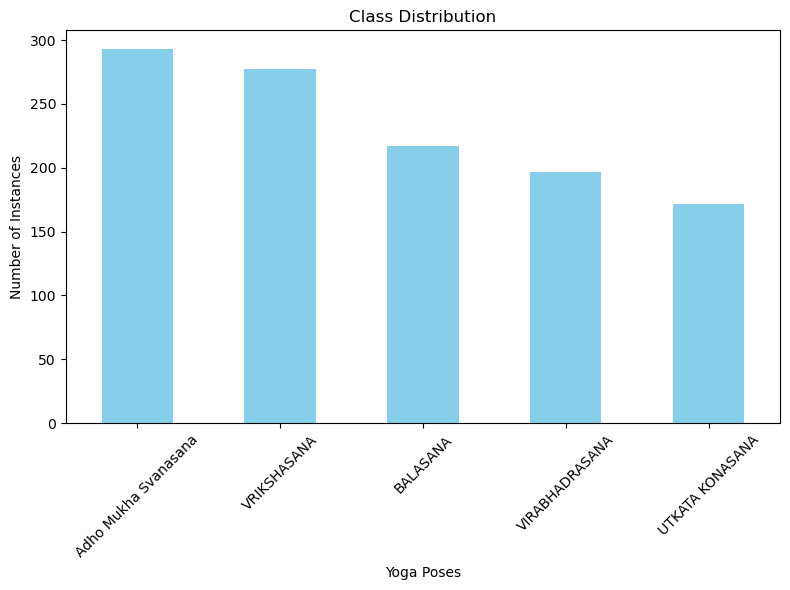

In [8]:
import matplotlib.pyplot as plt

# Assuming 'df' contains your dataset and 'pose_name' is the column representing classes
class_counts = df['pose_name'].value_counts()

# Plotting a bar plot for class distribution
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Yoga Poses')
plt.ylabel('Number of Instances')
plt.xticks(rotation=45)  # Rotating x-labels for better readability
plt.tight_layout()
plt.show()


#### Feature Encoding

In [9]:
# Encode the response variable into numrical values
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
df['label_enc'] = labelencoder.fit_transform(df['pose_name'])

In [10]:
classes= df[['label_enc','pose_name']].drop_duplicates()
classes

label_enc             pose_name
0          4           VRIKSHASANA
1          0  Adho Mukha Svanasana
2          2       UTKATA KONASANA
3          1              BALASANA
8          3        VIRABHADRASANA

In [11]:
# Adding pose names and encode values to a dictionary for display purposes
classes.set_index('label_enc', inplace= True)
yoga_pose=classes.to_dict()
yoga_pose_dict=yoga_pose['pose_name']
yoga_pose_dict

{4: 'VRIKSHASANA',
 0: 'Adho Mukha Svanasana',
 2: 'UTKATA KONASANA',
 1: 'BALASANA',
 3: 'VIRABHADRASANA'}

### Splitting data into train test split - 70-30 ratio

In [12]:
X=df.drop(['pose_name','label_enc'], axis=1) # independent variable
y=df['label_enc'] # dependent variable

In [13]:
A=X.columns

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.3, random_state=1234,stratify=y)

### LSTM Model Implementation

In [15]:
# reshaping the input array before applying to lstm
y_train_re= to_categorical(y_train).astype(int)
y_test_re= to_categorical(y_test).astype(int)

X_train_lstm= np.array(X_train)
X_test_lstm = np.array(X_test)
X_train_lstm=X_train_lstm.reshape(X_train_lstm.shape[0],1,X_train_lstm.shape[1])
X_test_lstm=X_test_lstm.reshape(X_test_lstm.shape[0],1,X_test_lstm.shape[1])

In [16]:
#LSTM Model Implementation
#tf.set_random_seed(122)
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', dropout=0.2, input_shape=(1,X_train_lstm.shape[2])))

model.add(LSTM(128, return_sequences=True, dropout=0.2, activation='relu'))

model.add(LSTM(64, return_sequences=False, dropout=0.2, activation='relu'))

model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(5, activation='softmax'))

#Compile
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
#Fitting LSTM model on train data
history_model_lstm=model.fit(X_train_lstm, y_train_re, epochs=200, validation_data=(X_test_lstm,y_test_re))

Epoch 1/200
26/26 [==============================] - 13s 85ms/step - loss: 1.6039 - categorical_accuracy: 0.2522 - val_loss: 1.5887 - val_categorical_accuracy: 0.2536
Epoch 2/200
26/26 [==============================] - 1s 28ms/step - loss: 1.5097 - categorical_accuracy: 0.3127 - val_loss: 1.3511 - val_categorical_accuracy: 0.4553
Epoch 3/200
26/26 [==============================] - 1s 37ms/step - loss: 1.2970 - categorical_accuracy: 0.4697 - val_loss: 1.0920 - val_categorical_accuracy: 0.5072
Epoch 4/200
26/26 [==============================] - 1s 28ms/step - loss: 1.1602 - categorical_accuracy: 0.4648 - val_loss: 1.0430 - val_categorical_accuracy: 0.5101
Epoch 5/200
26/26 [==============================] - 1s 24ms/step - loss: 1.1210 - categorical_accuracy: 0.4685 - val_loss: 1.0283 - val_categorical_accuracy: 0.4870
Epoch 6/200
26/26 [==============================] - 1s 26ms/step - loss: 1.0864 - categorical_accuracy: 0.5019 - val_loss: 1.0028 - val_categorical_accuracy: 0.5159
Epo

In [17]:
model.evaluate(X_test_lstm,y_test_re)

11/11 [==============================] - 0s 13ms/step - loss: 0.4182 - categorical_accuracy: 0.9020


[0.4181867241859436, 0.9020172953605652]

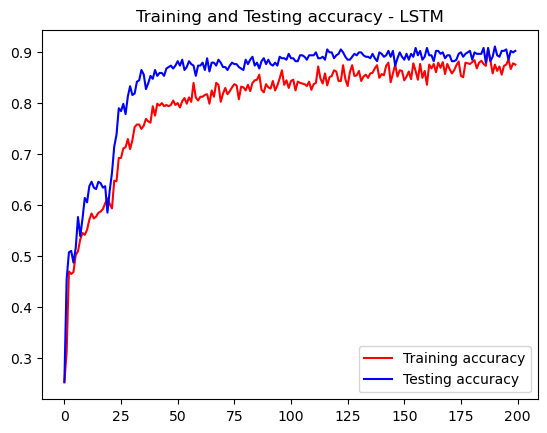

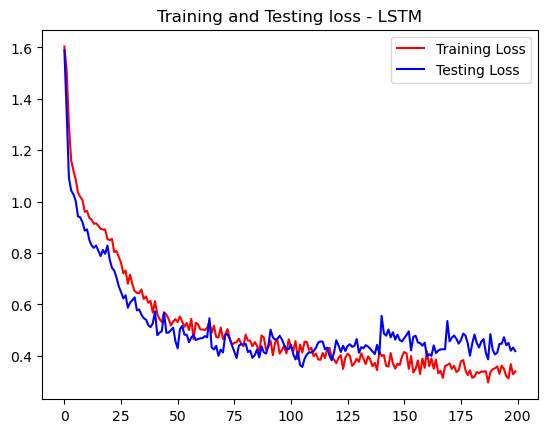

In [18]:
#Plotting Accuracy and loss Curve
%matplotlib inline
import matplotlib.pyplot as plt
acc= history_model_lstm.history['categorical_accuracy']
val_acc = history_model_lstm.history['val_categorical_accuracy']
loss = history_model_lstm.history['loss']
val_loss = history_model_lstm.history['val_loss']


epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Testing accuracy')
plt.title('Training and Testing accuracy - LSTM')
plt.legend()
plt.figure()

plt.plot(epochs, loss,'r', label='Training Loss')
plt.plot(epochs,val_loss,'b', label='Testing Loss')
plt.title('Training and Testing loss - LSTM')
plt.legend()

plt.show()

In [19]:
# Confusion report
from sklearn.metrics import confusion_matrix,classification_report
y_predicted = model.predict(X_test_lstm)
y_pred=[]
for i in y_predicted:
    y_pred.append(np.argmax(i))
y_pred1=pd.Series(y_pred)
y_pred1
print(classification_report(y_test,y_pred1))

11/11 [==============================] - 1s 9ms/step
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        88
           1       0.92      0.91      0.91        65
           2       0.81      0.75      0.78        52
           3       0.92      0.92      0.92        59
           4       0.84      0.93      0.88        83

    accuracy                           0.90       347
   macro avg       0.90      0.89      0.89       347
weighted avg       0.90      0.90      0.90       347



<AxesSubplot:>

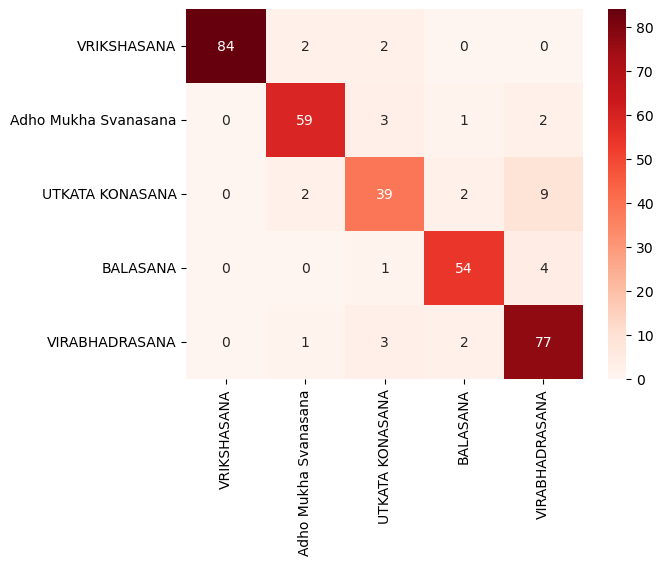

In [20]:
# Confusion metric
from sklearn import metrics
import seaborn as sns
cm=metrics.confusion_matrix(y_test,y_pred1)
# crete seaborn heatmap with required labels
sns.heatmap(cm,annot =True,cmap='Reds', fmt='g',xticklabels=yoga_pose_dict.values(), yticklabels=yoga_pose_dict.values())

###  1D CNN Model Implementation

In [21]:
# Reshaping the input array before applying to 1D CNN
X_train_re=np.array(X_train)
X_test_re=np.array(X_test)
sample_size=X_train_re.shape[0]
time_steps=X_test_re.shape[1]
input_dim=1
X_train_re=X_train_re.reshape(sample_size,time_steps,input_dim)
X_train_re.shape
sample_size1=X_test_re.shape[0]
time_steps1=X_test_re.shape[1]
input_dim1=1
X_test_re=X_test_re.reshape(sample_size1,time_steps1,input_dim1)
X_test_re.shape

(347, 99, 1)

In [22]:
# 1D CNN model Implementation

model_cnn = Sequential()
model_cnn.add(Conv1D(128,kernel_size=3,input_shape=(X_train_re.shape[1],1)))
model_cnn.add(Dropout(0.5))
model_cnn.add(MaxPooling1D(pool_size=1,name='MaxPooling1D'))
model_cnn.add(Flatten())
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dense(8, activation='relu'))
model_cnn.add(Dense(5, activation='softmax'))
# Compiling the model
model_cnn.compile(optimizer='Adam',loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# Fitting the model on train data
history_model_cnn=model_cnn.fit(X_train_re, y_train_re, epochs=200,validation_data=(X_test_re,y_test_re))

Epoch 1/200
26/26 [==============================] - 4s 75ms/step - loss: 1.3109 - categorical_accuracy: 0.4190 - val_loss: 1.1617 - val_categorical_accuracy: 0.4841
Epoch 2/200
26/26 [==============================] - 1s 50ms/step - loss: 1.1495 - categorical_accuracy: 0.5068 - val_loss: 1.0590 - val_categorical_accuracy: 0.5562
Epoch 3/200
26/26 [==============================] - 1s 53ms/step - loss: 1.0605 - categorical_accuracy: 0.5847 - val_loss: 0.9913 - val_categorical_accuracy: 0.5533
Epoch 4/200
26/26 [==============================] - 1s 53ms/step - loss: 0.9884 - categorical_accuracy: 0.6020 - val_loss: 0.9095 - val_categorical_accuracy: 0.6225
Epoch 5/200
26/26 [==============================] - 1s 50ms/step - loss: 0.9225 - categorical_accuracy: 0.6700 - val_loss: 0.8558 - val_categorical_accuracy: 0.6945
Epoch 6/200
26/26 [==============================] - 2s 59ms/step - loss: 0.8513 - categorical_accuracy: 0.7108 - val_loss: 0.7730 - val_categorical_accuracy: 0.7118
Epoc

In [23]:
#Evaluate the 1DCNN model on test data
model_cnn.evaluate(X_test_re,y_test_re)

11/11 [==============================] - 0s 20ms/step - loss: 0.3825 - categorical_accuracy: 0.9135


[0.3825025260448456, 0.9135446548461914]

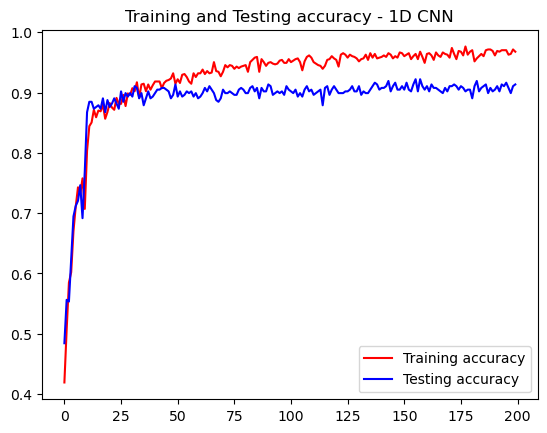

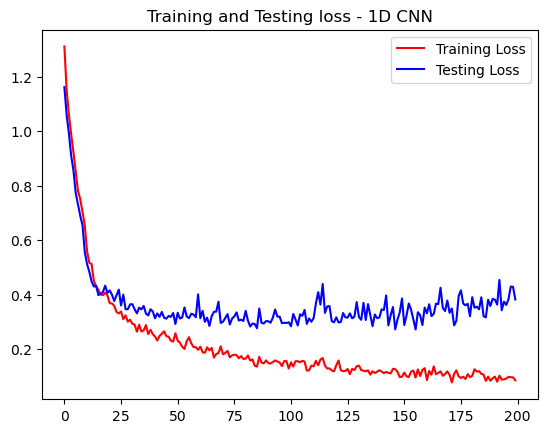

In [24]:
# Visualize Loss and Accuracy Plot of the 1D CNN
%matplotlib inline
import matplotlib.pyplot as plt
acc= history_model_cnn.history['categorical_accuracy']
val_acc = history_model_cnn.history['val_categorical_accuracy']
loss = history_model_cnn.history['loss']
val_loss = history_model_cnn.history['val_loss']


epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Testing accuracy')
plt.title('Training and Testing accuracy - 1D CNN')
plt.legend()
plt.figure()

plt.plot(epochs, loss,'r', label='Training Loss')
plt.plot(epochs,val_loss,'b', label='Testing Loss')
plt.title('Training and Testing loss - 1D CNN')
plt.legend()

plt.show()

## Applying Machine Learning Models on GeneratedLand_Mark dataset

In [25]:
# Fitting Generated landmark datset on Random Forest classifier
import numpy as np
seed = np.random.seed(22)
rng=np.random.RandomState(3)
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

#RandomizedSearchCV for hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
params= {'n_estimators':[10,20,30,40,50,60,70,80,90,100], 'max_features': ['log2','sqrt'],'max_depth':[2,4,6,8,10],'min_samples_split':[2,5],'min_samples_leaf':[1,2],'bootstrap':[True,False]}
random_forest=RandomizedSearchCV(RandomForestClassifier(random_state=rng),param_distributions=params,n_iter=5,scoring='accuracy',n_jobs=-1,cv=cv,verbose=3,random_state=rng)
random_forest.fit(X_train,y_train)


Fitting 15 folds for each of 5 candidates, totalling 75 fits


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=1),
                   estimator=RandomForestClassifier(random_state=RandomState(MT19937) at 0x1D22603FA40),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 4, 6, 8, 10],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100]},
                   random_state=RandomState(MT19937) at 0x1D22603FA40,
                   scoring='accuracy', verbose=3)

In [26]:
# Random Forest model Evaluation
# best parameters
print(random_forest.best_params_)

{'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': False}


In [27]:
print("Accuracy is:", random_forest.score(X_test,y_test))

Accuracy is: 0.9077809798270894


<AxesSubplot:>

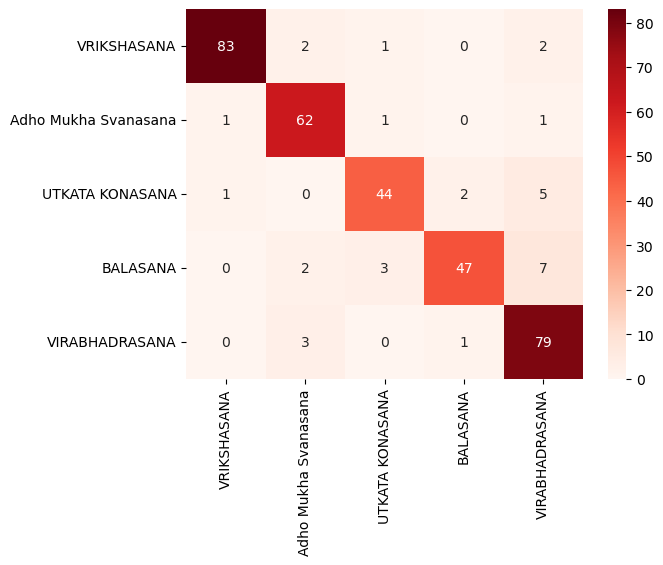

In [28]:
from sklearn import metrics
import seaborn as sns
y_pred_random=random_forest.predict(X_test)
random_forest_cm = metrics.confusion_matrix(y_test,y_pred_random)
# create seaborn heatmap with required labels
sns.heatmap(random_forest_cm,annot = True,cmap='Reds',fmt='g',xticklabels=yoga_pose_dict.values(),yticklabels=yoga_pose_dict.values())

In [29]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy-Random forest:",round((metrics.accuracy_score(y_test, y_pred_random))*100,2))
print("Precision-Random Forest:",round((metrics.precision_score(y_test, y_pred_random, average="macro"))*100,2))
print("Recall-Random Forest:", round((metrics.recall_score(y_test, y_pred_random, average="macro"))*100,2))
print("F1 Score -RandomForest:",round((metrics.f1_score(y_test,y_pred_random,average="macro"))*100,2))

Accuracy-Random forest: 90.78
Precision-Random Forest: 91.07
Recall-Random Forest: 89.83
F1 Score -RandomForest: 90.22


In [30]:
### XgBoost Classifier
seed = np.random.seed(22)
rng = np.random.RandomState(2)
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from xgboost import XGBClassifier

# RandomizedSearchCV for Hyperparameter tuning
params={'alpha':[0.001,0.01,0.1],'max_depth':[1,2,3,4,5,10], 'learning_rate':[0.1,0.25,0.5]}
xgboost=RandomizedSearchCV(XGBClassifier(random_state=rng),param_distributions=params,n_iter=5,scoring='accuracy',n_jobs=-1,cv=cv,verbose=3,random_state=rng)
xgboost.fit(X_train,y_train)

Fitting 15 folds for each of 5 candidates, totalling 75 fits


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=1),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           im...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                

In [31]:
print(xgboost.best_params_)
print("Accuracy is:", xgboost.score(X_test,y_test))

{'max_depth': 3, 'learning_rate': 0.25, 'alpha': 0.1}
Accuracy is: 0.9164265129682997


<AxesSubplot:>

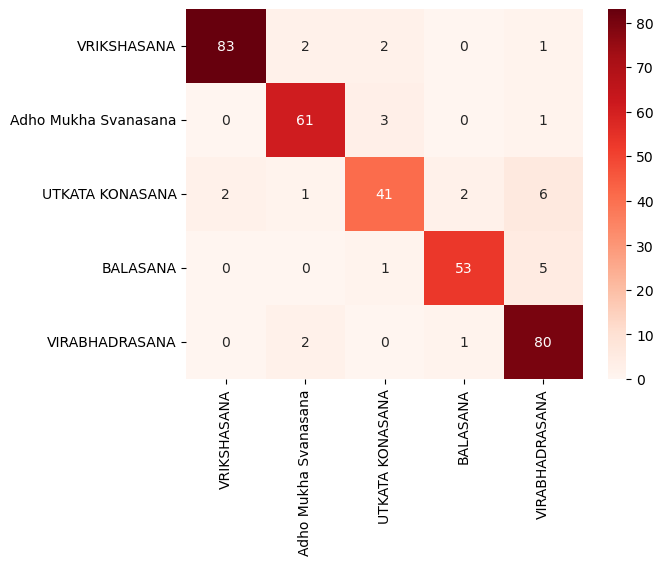

In [32]:
from sklearn import metrics
import seaborn as sns
y_pred_xgboost=xgboost.predict(X_test)
cm = metrics.confusion_matrix(y_test,y_pred_xgboost)
# create seaborn heatmap with required labels
sns.heatmap(cm,annot = True,cmap='Reds',fmt='g',xticklabels=yoga_pose_dict.values(),yticklabels=yoga_pose_dict.values())

In [33]:
print("Accuracy-xgboost:",round((metrics.accuracy_score(y_test, y_pred_xgboost))*100,2))
print("Precision-xgboost:",round((metrics.precision_score(y_test, y_pred_xgboost, average="macro"))*100,2))
print("Recall-xgboost:", round((metrics.recall_score(y_test, y_pred_xgboost, average="macro"))*100,2))
print("F1 Score -xgboost:",round((metrics.f1_score(y_test,y_pred_xgboost,average="macro"))*100,2))

Accuracy-xgboost: 91.64
Precision-xgboost: 91.59
Recall-xgboost: 90.65
F1 Score -xgboost: 91.0


In [34]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
seed=np.random.seed(33)
rng=np.random.RandomState(3)
cv= RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

param_grid={'C':[0.1,1,10,20,50,100],'kernel':['rbf','poly','sigmoid','linear'],'degree':[1,2,3,4,5,6]}
model_svm=RandomizedSearchCV(SVC(random_state =rng),param_distributions=param_grid,n_iter=5,scoring='accuracy',n_jobs=-1,cv=cv,verbose=3,random_state =rng)
model_svm.fit(X_train,y_train)


Fitting 15 folds for each of 5 candidates, totalling 75 fits


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=1),
                   estimator=SVC(random_state=RandomState(MT19937) at 0x1D22603F940),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10, 20, 50, 100],
                                        'degree': [1, 2, 3, 4, 5, 6],
                                        'kernel': ['rbf', 'poly', 'sigmoid',
                                                   'linear']},
                   random_state=RandomState(MT19937) at 0x1D22603F940,
                   scoring='accuracy', verbose=3)

In [35]:
print(model_svm.best_params_)
print("Accuracy is:", model_svm.score(X_test,y_test))

{'kernel': 'poly', 'degree': 6, 'C': 1}
Accuracy is: 0.9077809798270894


<AxesSubplot:>

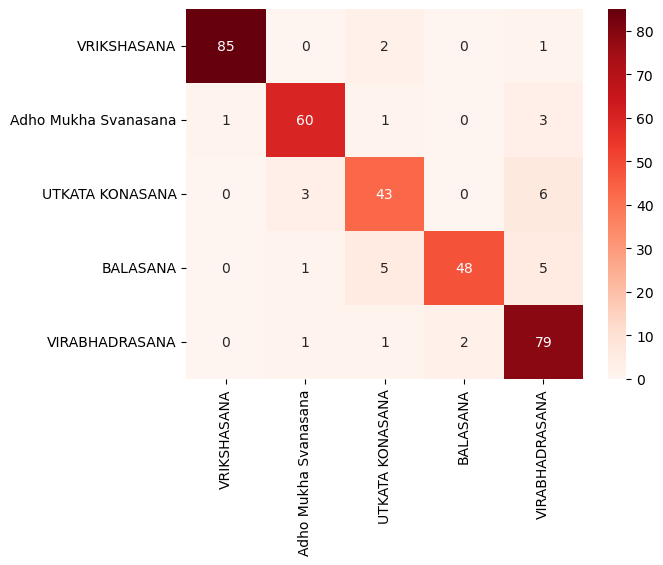

In [36]:
from sklearn import metrics
import seaborn as sns
y_pred_svm=model_svm.predict(X_test)
svm_cm = metrics.confusion_matrix(y_test,y_pred_svm)
# create seaborn heatmap with required labels
sns.heatmap(svm_cm,annot = True,cmap='Reds',fmt='g',xticklabels=yoga_pose_dict.values(),yticklabels=yoga_pose_dict.values())

In [37]:
print(classification_report(y_test,y_pred_svm))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98        88
           1       0.92      0.92      0.92        65
           2       0.83      0.83      0.83        52
           3       0.96      0.81      0.88        59
           4       0.84      0.95      0.89        83

    accuracy                           0.91       347
   macro avg       0.91      0.90      0.90       347
weighted avg       0.91      0.91      0.91       347



In [38]:
print("Accuracy-svm:",round((metrics.accuracy_score(y_test, y_pred_svm))*100,2))
print("Precision-svm:",round((metrics.precision_score(y_test, y_pred_svm, average="macro"))*100,2))
print("Recall-svm:", round((metrics.recall_score(y_test, y_pred_svm, average="macro"))*100,2))
print("F1 Score -svm:",round((metrics.f1_score(y_test,y_pred_svm,average="macro"))*100,2))

Accuracy-svm: 90.78
Precision-svm: 90.78
Recall-svm: 89.63
F1 Score -svm: 90.01


In [39]:
### Decision tree Classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
seed = np.random.seed(44)
rng= np.random.RandomState(4)
cv= RepeatedStratifiedKFold(n_splits=5,n_repeats=3, random_state=1)
param_grid={'max_depth':[10,30,50,60,90,100],'max_features':['auto','sqrt','log2'],'min_samples_split':[2,4,6]}
model_decision= RandomizedSearchCV(DecisionTreeClassifier(random_state =rng),param_distributions=param_grid,n_iter=5,scoring='accuracy',n_jobs=-1,cv=cv,verbose=3,random_state=rng)
model_decision.fit(X_train,y_train)

Fitting 15 folds for each of 5 candidates, totalling 75 fits


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=1),
                   estimator=DecisionTreeClassifier(random_state=RandomState(MT19937) at 0x1D230F34940),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'max_depth': [10, 30, 50, 60, 90, 100],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_split': [2, 4, 6]},
                   random_state=RandomState(MT19937) at 0x1D230F34940,
                   scoring='accuracy', verbose=3)

In [40]:
print(model_decision.best_params_)
print("Accuracy is:", model_decision.score(X_test,y_test))

{'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 30}
Accuracy is: 0.8645533141210374


<AxesSubplot:>

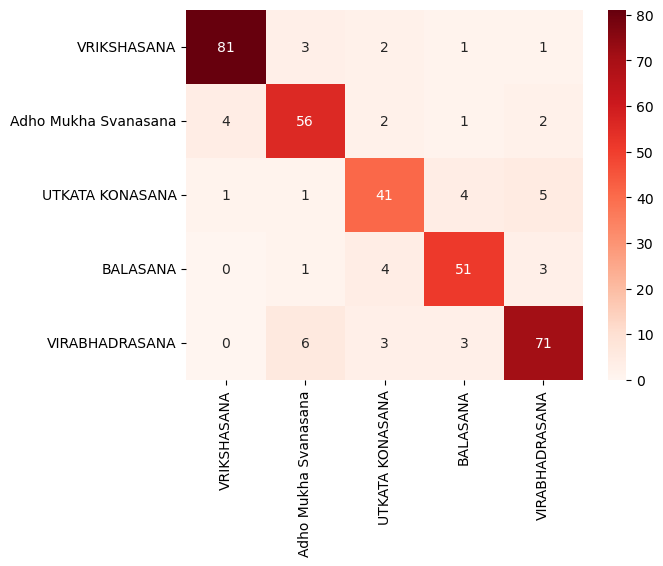

In [41]:
from sklearn import metrics
import seaborn as sns
y_pred_decision=model_decision.predict(X_test)
decision_cm = metrics.confusion_matrix(y_test,y_pred_decision)
# create seaborn heatmap with required labels
sns.heatmap(decision_cm,annot = True,cmap='Reds',fmt='g',xticklabels=yoga_pose_dict.values(),yticklabels=yoga_pose_dict.values())

In [42]:
print("Accuracy-decision tree:",round((metrics.accuracy_score(y_test, y_pred_decision))*100,2))
print("Precision-decision tree:",round((metrics.precision_score(y_test, y_pred_decision, average="macro"))*100,2))
print("Recall-decision tree:", round((metrics.recall_score(y_test, y_pred_decision, average="macro"))*100,2))
print("F1 Score -decision tree:",round((metrics.f1_score(y_test,y_pred_decision,average="macro"))*100,2))

Accuracy-decision tree: 86.46
Precision-decision tree: 85.64
Recall-decision tree: 85.81
F1 Score -decision tree: 85.71


C:\Users\jhaan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\jhaan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

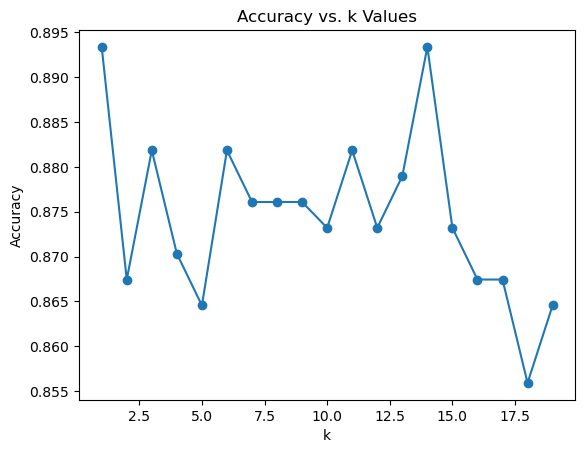

In [43]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

k_values = list(range(1, 20))
accuracy_values = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_values.append(accuracy)

plt.plot(k_values, accuracy_values, marker='o')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. k Values')
plt.show()

In [44]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

C:\Users\jhaan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [45]:
print("Accuracy-knn:",round((metrics.accuracy_score(y_test, y_pred))*100,2))

Accuracy-knn: 89.34


### saving the model

In [46]:
import pickle
file_name='xgb-reg_fix2.pkl'
pickle.dump(xgboost,open(file_name,"wb"))
xgb_model_loaded=pickle.load(open("xgb-reg_fix.pkl","rb"))

In [47]:
xgb_model_loaded=pickle.load(open("xgb-reg_fix.pkl","rb"))

### Yoga Pose detection from Image

In [48]:
# read and display the input Image
import matplotlib.pyplot as plt


In [49]:
def poseclassify(path):
    sample_img=cv2.imread(path)
    plt.figure(figsize=[10,10])
    plt.title("Sample_image")
    plt.axis("off")
    plt.imshow(sample_img)
    plt.imshow(sample_img[:,:,::-1])
    plt.show()
    
    # Define pose estimation and skeltal image drawing object
    mp_drawing = mp.solutions.drawing_utils
    mp_pose = mp.solutions.pose
    pose = mp_pose.Pose(static_image_mode=True,model_complexity=2)
    img_copy = sample_img.copy()
    #Convert BGR to RGB format and apply the Blazepose pose estimation model
    results = pose.process(cv2.cvtColor(sample_img,cv2.COLOR_BGR2RGB))
    
    
    # to draw it in 3D Space
    mp_drawing.plot_landmarks(results.pose_world_landmarks,mp_pose.POSE_CONNECTIONS)
    
    # Extract the landmark data and pass to xgboost model for prediction
    landmarks = results.pose_landmarks.landmark

    # Flatten Array
    pose_row = list(np.array([[landmark.x, landmark.y,landmark.z] for landmark in landmarks]).flatten())
    X = pd.DataFrame([pose_row])

    # Xgboost prediction
    X.columns = A
    body_language_class = xgb_model_loaded.predict(X)[0]
    body_language_prob = xgb_model_loaded.predict_proba(X)[0]
    print(body_language_class, body_language_prob)

    pose_detected= yoga_pose_dict[body_language_class]
    prob=(round(body_language_prob[np.argmax(body_language_prob)],2))
    print(" The pose detected is:", pose_detected)
    print("probablity :", prob)

    if results.pose_landmarks:
        mp_drawing.draw_landmarks(img_copy,results.pose_landmarks,mp_pose.POSE_CONNECTIONS,
                                 mp_drawing.DrawingSpec(color=((255,127,80)), thickness=1,circle_radius=2),
                                 mp_drawing.DrawingSpec(color=(50,205,50),thickness =1,circle_radius=2)
                                 )
        fig=plt.figure(figsize=[10,10])
        plt.title("output-image")
        plt.axis("off")
        plt.imshow(img_copy[:,:,::-1])
        plt.show()

    

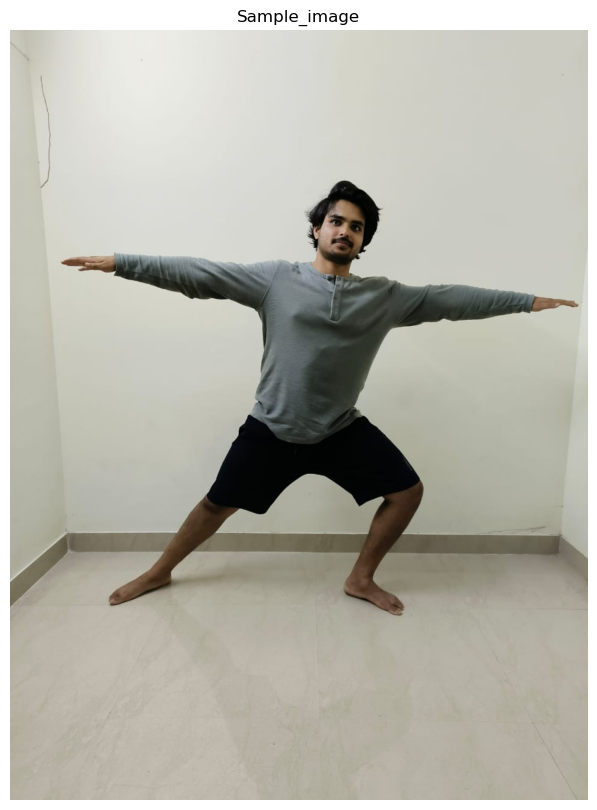

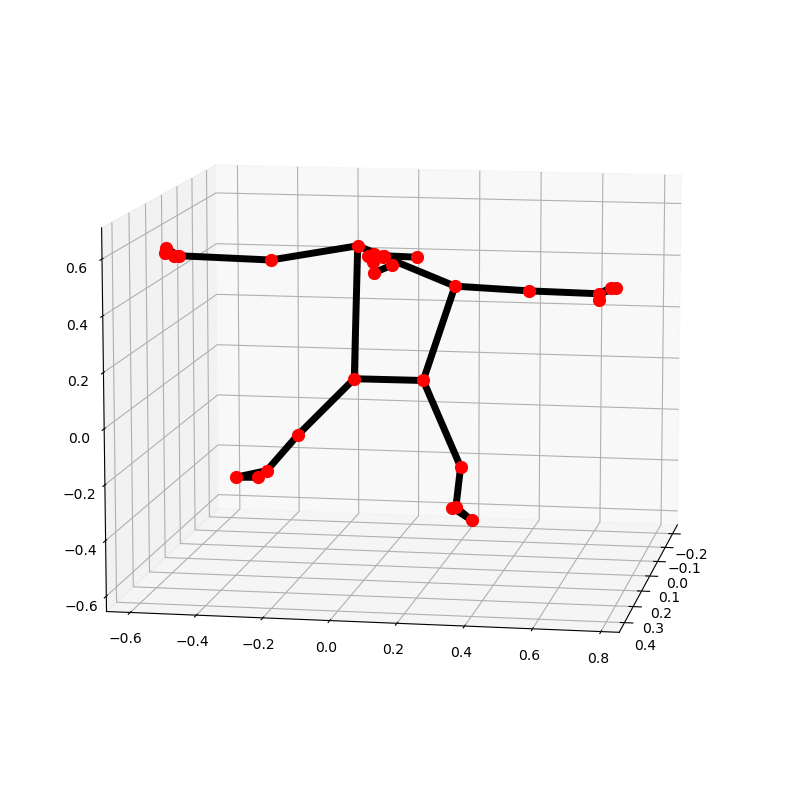

3 [4.1104291e-04 2.7608846e-03 5.8537070e-02 9.3333369e-01 4.9572806e-03]
 The pose detected is: VIRABHADRASANA
probablity : 0.93


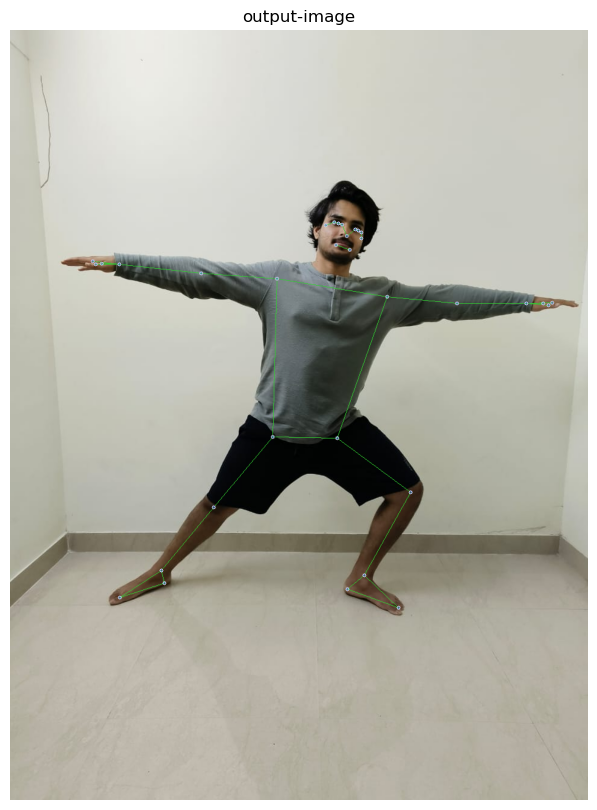

In [50]:
poseclassify("C:\\Users\\jhaan\\Desktop\\Anand_01.jpg")

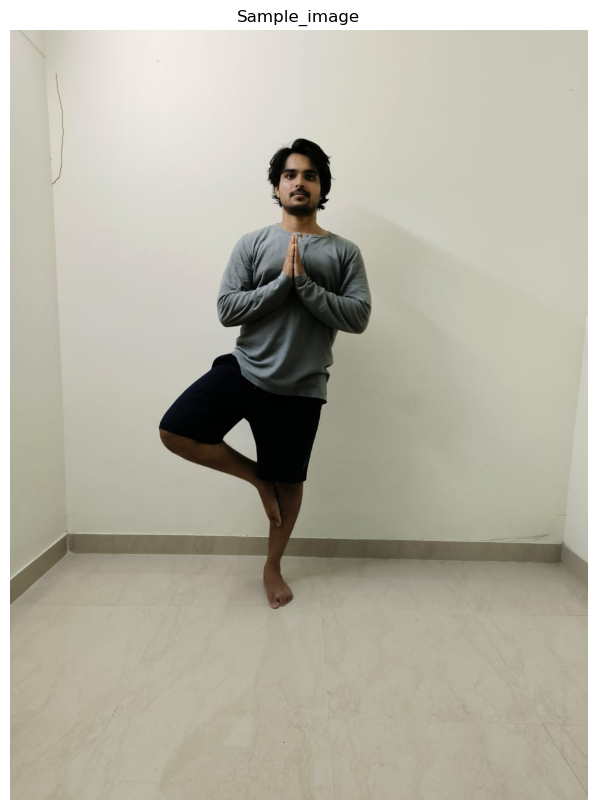

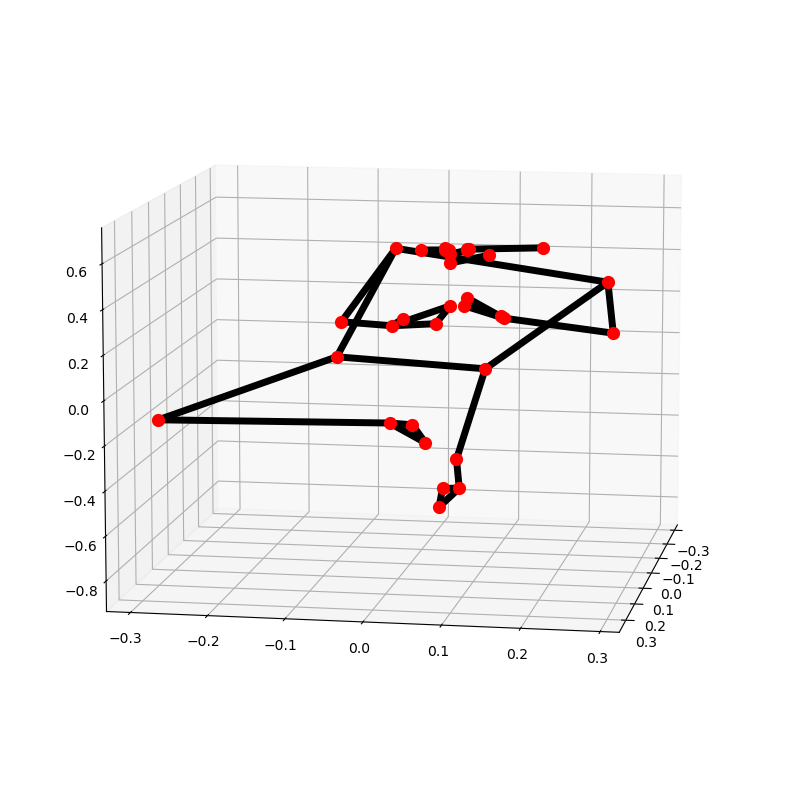

4 [5.4400192e-05 1.2273241e-04 3.3141478e-04 1.3932917e-04 9.9935216e-01]
 The pose detected is: VRIKSHASANA
probablity : 1.0


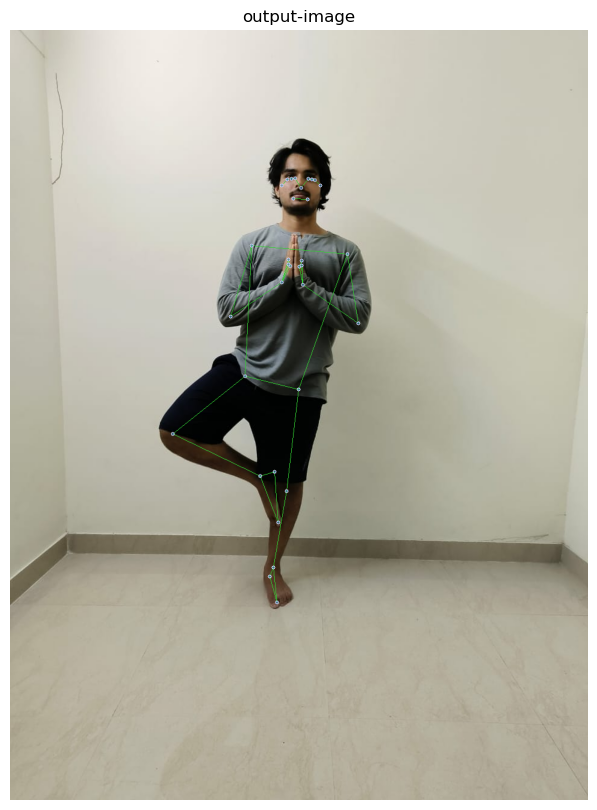

In [51]:
poseclassify("C:\\Users\\jhaan\\Desktop\\Anand_02.jpg")

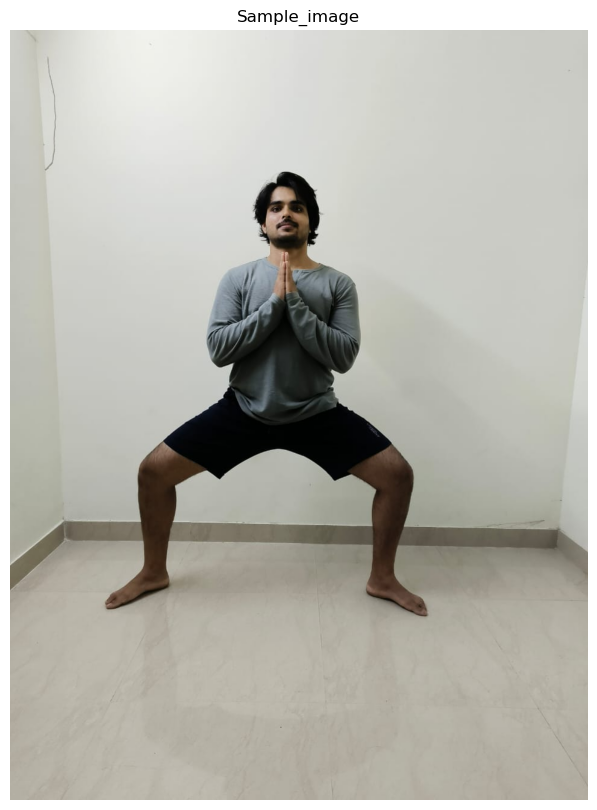

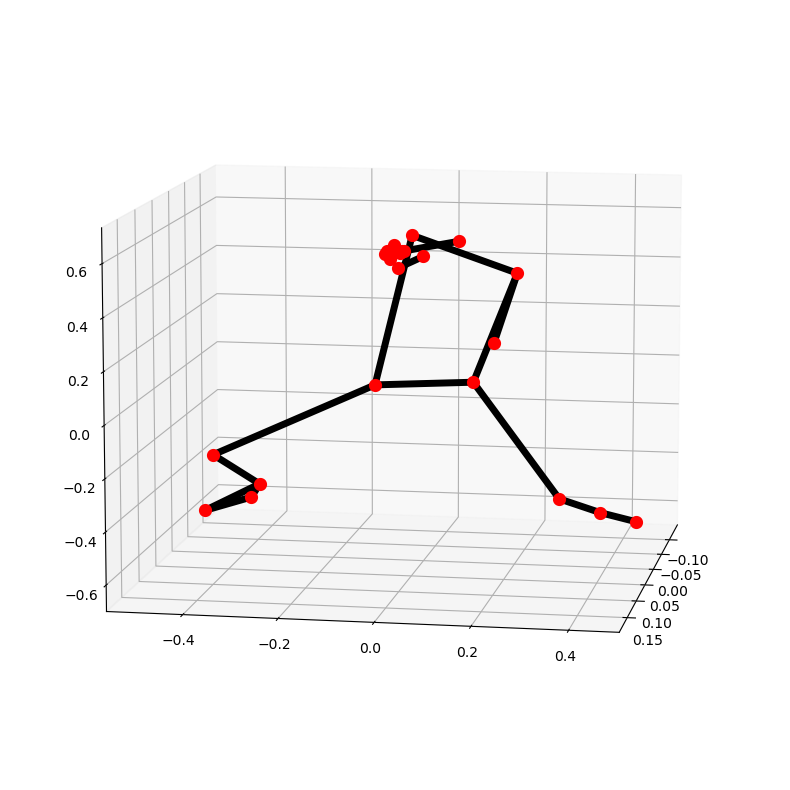

2 [5.6868169e-04 7.0563750e-04 9.9182796e-01 1.5963842e-03 5.3013591e-03]
 The pose detected is: UTKATA KONASANA
probablity : 0.99


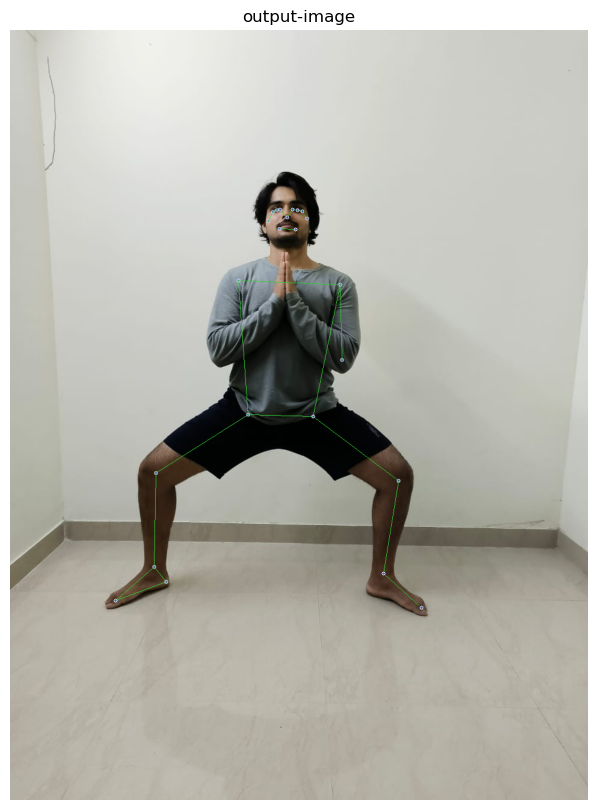

In [52]:
poseclassify("C:\\Users\\jhaan\\Desktop\\Anand_03.jpg")

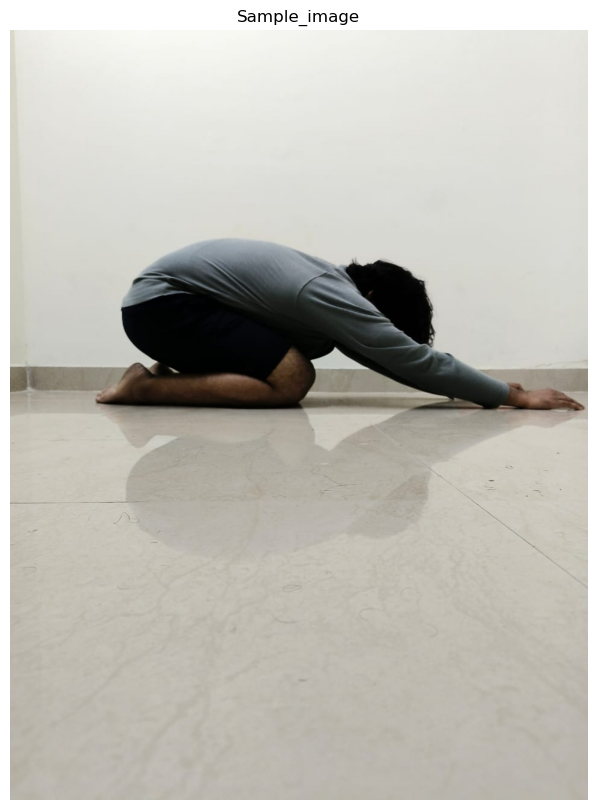

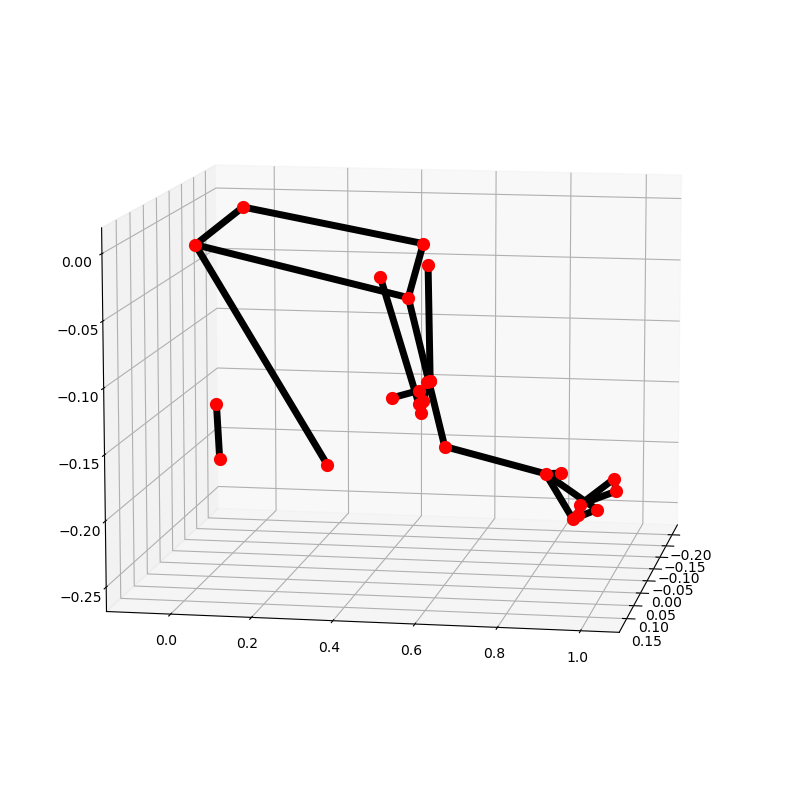

1 [0.10909098 0.83369267 0.00393354 0.04577509 0.00750775]
 The pose detected is: BALASANA
probablity : 0.83


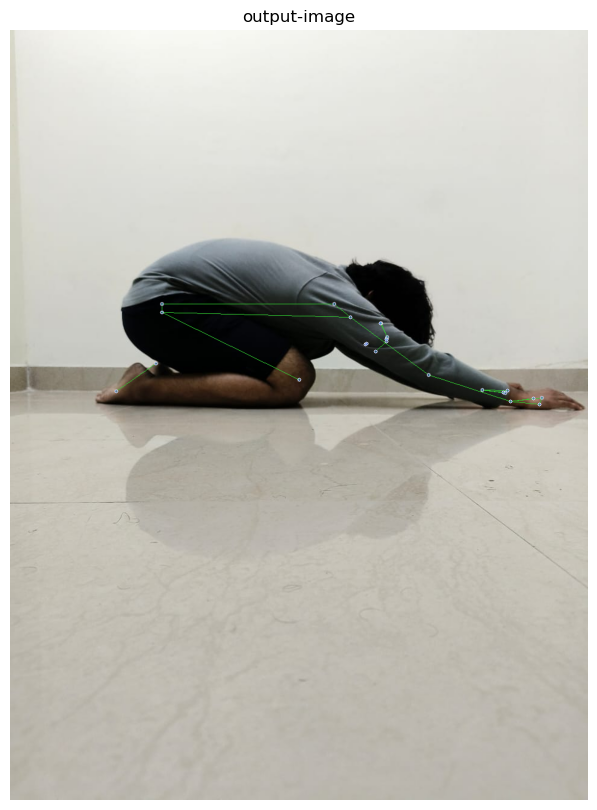

In [53]:
poseclassify("C:\\Users\\jhaan\\Desktop\\Anand_04.jpg")

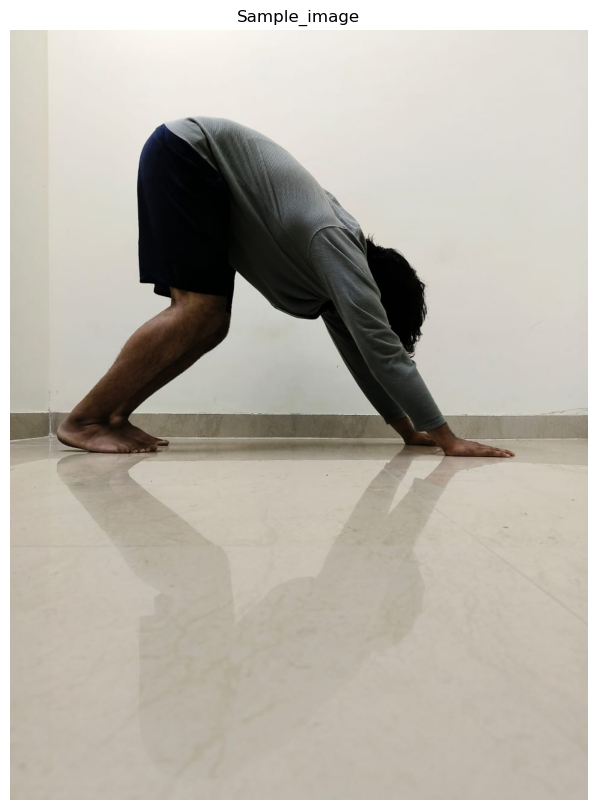

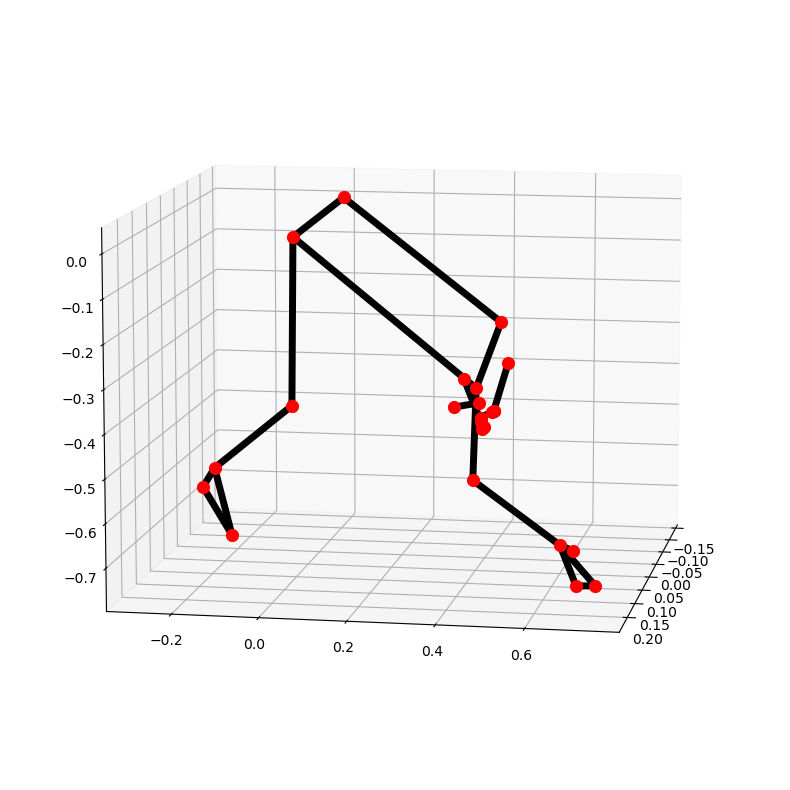

0 [0.7829191  0.20188373 0.00104496 0.01267623 0.00147592]
 The pose detected is: Adho Mukha Svanasana
probablity : 0.78


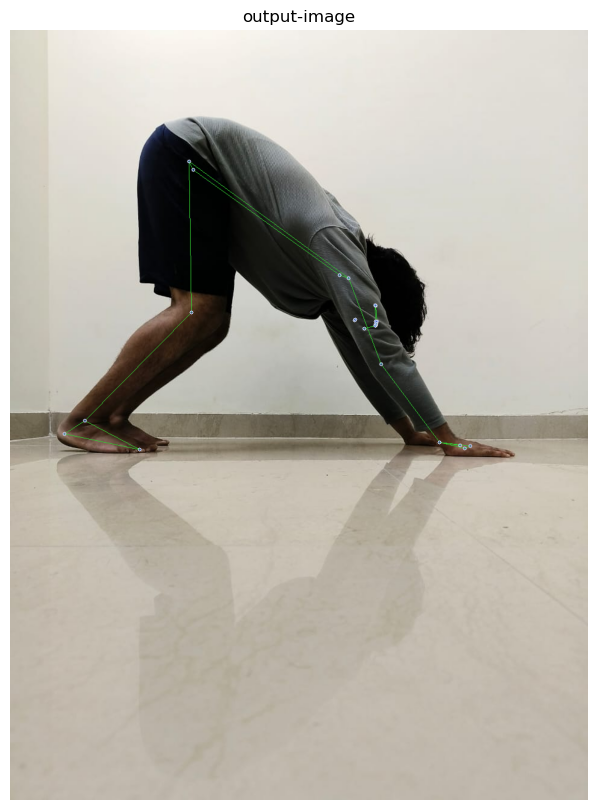

In [54]:
poseclassify("C:\\Users\\jhaan\\Desktop\\Anand_05.jpg")

### Pose Detection from Real-Time Video

In [55]:
def yogabenifit(yoga_pose):
    if yoga_pose == "VIRABHADRASANA":
        cv2.putText(image,"It strengthen the arms, shoulders, and legs.", (20, frame.shape[0] - 100),cv2.FONT_HERSHEY_SIMPLEX, 0.5,(255,0,0),1,cv2.LINE_AA)
        cv2.putText(image,"It maintain balance in the body.", (20, frame.shape[0] - 80),cv2.FONT_HERSHEY_SIMPLEX, 0.5,(255,0,0),1,cv2.LINE_AA)
        cv2.putText(image,"It increase stamina, muscle endurance and relieve tension", (20, frame.shape[0] - 60),cv2.FONT_HERSHEY_SIMPLEX, 0.5,(255,0,0),1,cv2.LINE_AA)
       
    if yoga_pose == "Adho Mukha Svanasana":
        cv2.putText(image,"It may help improve digestion.", (20, frame.shape[0] - 100),cv2.FONT_HERSHEY_SIMPLEX, 0.5,(255,0,0),1,cv2.LINE_AA)
        cv2.putText(image,"It might help stimulate circulation.", (20, frame.shape[0] - 80),cv2.FONT_HERSHEY_SIMPLEX, 0.5,(255,0,0),1,cv2.LINE_AA)
        cv2.putText(image,"It may help to relieve leg pain and ankle pain.", (20, frame.shape[0] - 60),cv2.FONT_HERSHEY_SIMPLEX, 0.5,(255,0,0),1,cv2.LINE_AA)
                   
    if yoga_pose == "UTKATA KONASANA":
        cv2.putText(image," It strengthens the pelvic floor, thighs, knees, and ankles.", (20, frame.shape[0] - 100),cv2.FONT_HERSHEY_SIMPLEX, 0.5,(255,0,0),1,cv2.LINE_AA)
        cv2.putText(image,"It strengthens the spine and activates the Muladhara, Swadhisthan, and Manipur chakra. ", (20, frame.shape[0] - 80),cv2.FONT_HERSHEY_SIMPLEX, 0.5,(255,0,0),1,cv2.LINE_AA)
        cv2.putText(image,"It also activates the heart chakra and promotes confidence and compassion.", (20, frame.shape[0] - 60),cv2.FONT_HERSHEY_SIMPLEX, 0.5,(255,0,0),1,cv2.LINE_AA)
                                 
                    
    if yoga_pose == "BALASANA":
        cv2.putText(image,"Enhances blood circulation", (20, frame.shape[0] - 100),cv2.FONT_HERSHEY_SIMPLEX, 0.5,(255,0,0),1,cv2.LINE_AA)
        cv2.putText(image,"Strengthens the ligaments in the knees", (20, frame.shape[0] - 80),cv2.FONT_HERSHEY_SIMPLEX, 0.5,(255,0,0),1,cv2.LINE_AA)
        cv2.putText(image,"Effectively calms the mind", (20, frame.shape[0] - 60),cv2.FONT_HERSHEY_SIMPLEX, 0.5,(255,0,0),1,cv2.LINE_AA)
                                 
                                 
                  
    if yoga_pose == "VRIKSHASANA":
        cv2.putText(image,"Boosts the balance of the body", (20, frame.shape[0] - 100),cv2.FONT_HERSHEY_SIMPLEX, 0.5,(255,0,0),1,cv2.LINE_AA)
        cv2.putText(image,"Improves the posture.", (20, frame.shape[0] - 80),cv2.FONT_HERSHEY_SIMPLEX, 0.5,(255,0,0),1,cv2.LINE_AA)
        cv2.putText(image,"Tones the muscles of your legs.", (20, frame.shape[0] - 60),cv2.FONT_HERSHEY_SIMPLEX, 0.5,(255,0,0),1,cv2.LINE_AA)
                                 
                                 
 
                    




In [56]:

#pip install pyttsx3
import pyttsx3

# Initialize the text-to-speech engine
engine = pyttsx3.init()
def text2speech(yoga_pose):
    
    engine.say(f"it is {yoga_pose} pose ")
    engine.runAndWait()

In [57]:
cap = cv2.VideoCapture(0)

with mp_pose.Pose(min_detection_confidence=0.9, min_tracking_confidence=0.9) as pose:
    while cap.isOpened():
        
        ret, frame =cap.read()
        
        image= cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
        
        results = pose.process(image)
        
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                  mp_drawing.DrawingSpec(color=(255,127,80), thickness=2, circle_radius=2),
                                  mp_drawing.DrawingSpec(color=(50,205,50), thickness=2, circle_radius=2))
        
        
        
        try:
            if results.pose_landmarks is not None:
                
                landmarks = results.pose_landmarks.landmark
                pose_row=list(np.array([[landmark.x,landmark.y,landmark.x] for landmark in landmarks]).flatten())
                X= pd.DataFrame([pose_row])
                X.columns = A
                body_language_class = xgb_model_loaded.predict(X)[0]
                body_language_prob =xgb_model_loaded.predict_proba(X)[0]

                yoga_pose= yoga_pose_dict[body_language_class]
                #print("pose detected:", yoga_pose)
                prob=(round(body_language_prob[np.argmax(body_language_prob)],2))

                if prob>=0.85:
                    grade="Very Good"

                if prob<0.85 and prob>=0.80:
                    grade="Good"

                if prob<0.80:
                    grade="Needs Improvement"

                cv2.rectangle(image,(0,0), (1080,60), (0,0,16), -1)

                if prob>=0.75 and len(landmarks) >= 25:
                    cv2.putText(image,"Yoga Pose Detected",(150,12), cv2.FONT_HERSHEY_SIMPLEX,0.5,(255,255,255), 1,cv2.LINE_AA)
                    cv2.putText(image, yoga_pose,(150,35),cv2.FONT_HERSHEY_SIMPLEX,0.5,(255,255,255), 1, cv2.LINE_AA)
                    
                    if prob>=0.80:
                        
                        yogabenifit(yoga_pose)
                    

                    cv2.putText(image,"Probability", (30,12),cv2.FONT_HERSHEY_SIMPLEX, 0.5,(255,255,255),1,cv2.LINE_AA)
                    cv2.putText(image,str(round(body_language_prob[np.argmax(body_language_prob)],2)), (30,35),cv2.FONT_HERSHEY_SIMPLEX, 0.5,(255,255,255),1,cv2.LINE_AA)

                    cv2.putText(image,"System_comment", (400,12),cv2.FONT_HERSHEY_SIMPLEX, 0.5,(255,255,255),1,cv2.LINE_AA)

                    cv2.putText(image,grade, (400,35),cv2.FONT_HERSHEY_SIMPLEX, 0.5,(255,255,255),1,cv2.LINE_AA)

                else:

                    cv2.putText(image,"No pose detected", (180,30),cv2.FONT_HERSHEY_SIMPLEX, 0.8,(255,255,255),1,cv2.LINE_AA)
                    cv2.putText(image,"please let full body come into the frame", (100,50),cv2.FONT_HERSHEY_SIMPLEX, 0.8,(255,255,255),1,cv2.LINE_AA)


                if prob >= 0.75:
                    if not in_pose:
                        in_pose = True
                        pose_start_time = cap.get(cv2.CAP_PROP_POS_MSEC)
                        # Speak when the pose is initially detected
                        
                        
                    else:
                        pose_end_time = cap.get(cv2.CAP_PROP_POS_MSEC)
                        total_time = (pose_end_time - pose_start_time) / 1000  # Convert to seconds
                        
                       
                        # Display the result
                        cv2.putText(image, f"Total time in {yoga_pose}: {total_time} seconds",
                                    (150, 80), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 0), 1, cv2.LINE_AA)
                        
                        
                        
                        
                    if not in_pose:
                        in_pose = True
                        pose_start_time = cap.get(cv2.CAP_PROP_POS_MSEC)
                       
                    else:
                        pose_end_time = cap.get(cv2.CAP_PROP_POS_MSEC)
                        total_time = (pose_end_time - pose_start_time) / 1000 
                        
                        
                        if total_time >= 2:  # Example: Speak after 5 seconds in the pose
                            # Speak after certain time spent in the pose
                            text2speech(yoga_pose)
                            
                       


                else:
                    in_pose = False
            
            #else:
                
                #print("")

        except Exception as e:
            print(e)
        
        
        
        
        cv2.namedWindow("Resized_pose_detection_window", cv2.WINDOW_NORMAL)
        
        cv2.resizeWindow("Resized_pose_detection_window",2000, 1000)
                
        cv2.imshow("Resized_pose_detection_window", image) 
        
        
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

            
            
            
cap.release()
cv2.destroyAllWindows()
            
        